In [1]:
!pip install modAL

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import csv
import time
import pickle
import pandas as pd
import numpy as np
from functools import partial
import seaborn as sn


import tensorflow as tf
from tensorflow import keras

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator

from modAL.models import ActiveLearner
from modAL.uncertainty import *
from modAL.batch import uncertainty_batch_sampling

import matplotlib.pyplot as plt
%matplotlib inline

import warnings

In [3]:
filePathName = './RandomForest.pkl'
loaded_model = pickle.load(open(filePathName, 'rb'))

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [4]:
useStats = 1
useAttributeName = 1
useSample1 = 0
useSample2 = 0
## Using descriptive stats and attribute name

In [5]:
dict_label = {
    'numeric': 0,
    'categorical': 1,
    'datetime': 2,
    'sentence': 3,
    'url': 4,
    'embedded-number': 5,
    'list': 6,
    'not-generalizable': 7,
    'context-specific': 8
}

dict_label_list = [k for k,v in sorted(dict_label.items(), key = lambda x: x[1])]
print(dict_label_list)

['numeric', 'categorical', 'datetime', 'sentence', 'url', 'embedded-number', 'list', 'not-generalizable', 'context-specific']


In [6]:
def ProcessStats(data,y):

    data1 = data[['total_vals', 'num_nans', '%_nans', 'num_of_dist_val', '%_dist_val', 'mean', 'std_dev', 'min_val', 'max_val','has_delimiters', 'has_url', 'has_email', 'has_date', 'mean_word_count',
       'std_dev_word_count', 'mean_stopword_total', 'stdev_stopword_total',
       'mean_char_count', 'stdev_char_count', 'mean_whitespace_count',
       'stdev_whitespace_count', 'mean_delim_count', 'stdev_delim_count',
       'is_list', 'is_long_sentence']]
    data1 = data1.reset_index(drop=True)
    data1 = data1.fillna(0)

    y.y_act = y.y_act.astype(float)
    
    return data1

vectorizerName = CountVectorizer(ngram_range=(2, 2), analyzer='char')
vectorizerSample = CountVectorizer(ngram_range=(2, 2), analyzer='char')

def FeatureExtraction(data,data1,flag):

    arr = data['Attribute_name'].values
    arr = [str(x) for x in arr]
    
    arr1 = data['sample_1'].values
    arr1 = [str(x) for x in arr1]
    arr2 = data['sample_2'].values
    arr2 = [str(x) for x in arr2]
    arr3 = data['sample_3'].values
    arr3 = [str(x) for x in arr3]    
    #print(len(arr1),len(arr2))
    if flag:
        X = vectorizerName.fit_transform(arr)
        X1 = vectorizerSample.fit_transform(arr1)
        X2 = vectorizerSample.transform(arr2)   
    else:
        X = vectorizerName.transform(arr)
        X1 = vectorizerSample.transform(arr1)
        X2 = vectorizerSample.transform(arr2)        
        
#     print(f"> Length of vectorized feature_names: {len(vectorizer.get_feature_names())}")

    attr_df = pd.DataFrame(X.toarray())
    sample1_df = pd.DataFrame(X1.toarray())
    sample2_df = pd.DataFrame(X2.toarray())
    #print(len(data1),len(attr_df),len(sample1_df),len(sample2_df))

    if useSample1: data2 = sample1_df
    if useSample2: data2 = sample2_df    
    
    data2 = pd.concat([data1, attr_df], axis=1, sort=False)
    #print(len(data2))
    return data2



In [7]:
def get_data(sim_size = 0.9):
    """
    sim_size is the % of training data that goes into simulation set.
    """
    xtrain = pd.read_csv('./data_train.csv')
    xtest = pd.read_csv('./data_test.csv')

    y_train = xtrain.loc[:,['y_act']]
    y_test = xtest.loc[:,['y_act']]
    y_train['y_act'] = [dict_label[i] for i in y_train['y_act']]
    y_test['y_act'] = [dict_label[i] for i in y_test['y_act']]
    
    xtrain1 = ProcessStats(xtrain,y_train)
    xtest1 = ProcessStats(xtest,y_test)


    X_train = FeatureExtraction(xtrain,xtrain1,1)
    X_test = FeatureExtraction(xtest,xtest1,0)


    X_train_new = X_train.reset_index(drop=True)
    y_train_new = y_train.reset_index(drop=True)
    X_train_new = X_train_new.values
    y_train_new = y_train_new.values
    
    # setting up data
    X_train_AL, X_simulation_AL, y_train_AL, y_simulation_AL = train_test_split(X_train_new, y_train, test_size=sim_size, random_state=4, stratify=y_train, shuffle=True)
    # Start AL loops simulated with a part of the test data
    X_simulation_df = pd.DataFrame(X_simulation_AL)
    y_simulation_df = pd.DataFrame(y_simulation_AL)
    # making copies of existing X_test and y_test data
    X_test_AL = pd.DataFrame(X_test)
    y_test_AL = pd.DataFrame(y_test)
    
    assert len(X_train_AL) == len(y_train_AL)
    assert len(X_simulation_df) == len(y_simulation_df)
    assert len(X_test_AL) == len(y_test_AL)
    return X_train_AL, y_train_AL, X_simulation_df, y_simulation_df, X_test_AL, y_test_AL

X_train, y_train, X_sim, y_sim, X_test, y_test = get_data()
print(f"Training set size: {len(X_train)}, Simulation set size: {len(X_sim)}, Test set size: {len(X_test)}")


Training set size: 793, Simulation set size: 7143, Test set size: 1985


In [8]:
print(X_train.shape, y_train.shape)
print(X_sim.shape, y_sim.shape)
print(X_test.shape, y_test.shape)

(793, 1478) (793, 1)
(7143, 1478) (7143, 1)
(1985, 1478) (1985, 1)


In [9]:
def grid_parameter_search(X_train, y_train, X_test, y_test, n_estimators_grid, max_depth_grid, query_size):
    best_model_score = 0
    
    preset_batch = partial(uncertainty_sampling, n_instances=query_size)
    
    for ne in n_estimators_grid:
        for md in max_depth_grid:
            learner = ActiveLearner(
                  estimator=RandomForestClassifier(n_estimators=ne, max_depth=md, random_state=100),
                  X_training=X_train, y_training=y_train,
                  query_strategy=preset_batch
                )
            score = learner.score(X_test, y_test)
            print(f"[n_estimator: {ne}, max_depth: {md}, accuracy: {score}]")
            if best_model_score < score:
                best_ne = ne
                best_md = md
                best_model_score = score
                bestPerformingModel = learner
    print(f"best model found at ne:{best_ne}, md:{best_md}, at score:{best_model_score}")
    return learner, best_ne, best_md, best_model_score


#learner, best_ne, best_md, best_model_score = grid_parameter_search(X_train, y_train, X_sim, y_sim, [i*100 for i in range(1,11)],[i*100 for i in range(11)], 100)
#print(f"[BEST OBTAINED RF ESTIMATOR] === [n_estimator: {best_ne}, max_depth: {best_md}, accuracy: {best_model_score}]")

In [10]:
def save_his(data, full_path):
    assert data != None and len(data.items()) > 0, "data should not be empty"
    
    with open(full_path, "w") as outfile:
        writer = csv.writer(outfile)
        writer.writerow(list(data.keys()))
        writer.writerows(zip(*data.values()))
    

test_data_1 = [i for i in range(100)]
test_data_2 = [i*2 for i in range(100)]
test_data_3 = [i*3 for i in range(100)]
test_data_4 = [i*4 for i in range(100)]
data = {"num_queries": test_data_1, "time": test_data_2, "total_time":test_data_3, "test_accuracy":test_data_4}

save_his(data, "./his/test.csv")

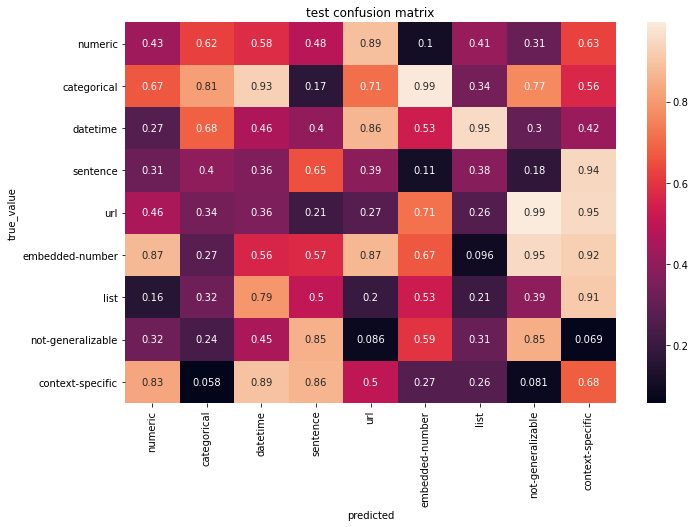

In [11]:
con_matrix = np.random.rand(9,9)
title = "test confusion matrix"
img_folder = "./img"

def save_con_matrix(con_matrix, title, full_path, show=False):
    plt.figure(figsize = (11,7))
    df_cm = pd.DataFrame(con_matrix, index = dict_label_list, columns = dict_label_list)
    sn.heatmap(con_matrix, annot=True, xticklabels=dict_label_list, yticklabels=dict_label_list, ) # font size

    plt.title(title) # title with fontsize 20
    plt.xlabel('predicted') # x-axis label with fontsize 15
    plt.ylabel('true_value') # y-axis label with fontsize 15

    plt.savefig(full_path)

save_con_matrix(con_matrix, title, img_folder + "/test_matrix.png")

In [12]:
feed_his_folder = "./feed"

test_feed = np.random.rand(9,9)

def save_feed(feed, full_path):
    file = open(full_path, 'wb')
    pickle.dump(feed, file)
    
def load_feed(full_path):
    file = open(full_path, 'rb')
    return pickle.load(file)

save_feed(test_feed, feed_his_folder+"/test.pkl")
re = load_feed(feed_his_folder+"/test.pkl")

assert np.all(test_feed == re)

/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



*********** QUERY 0 ***********remain:7143
Nodes returned for query in iteration 0: [1508 1979 5322   99   78 2908 2736 6394 1517 2649]
(793, 1478) (793, 1)
(7143, 1478) (7143, 1)
(1985, 1478) (1985, 1)


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8574307304785894, sim_acc:0.5834852095892331, train_acc:1.0

[INTERMEDIATE] Time taken for query 0: 26.756320238113403

[INTERMEDIATE] Total time taken 0: 26.756922960281372
saving data
completed


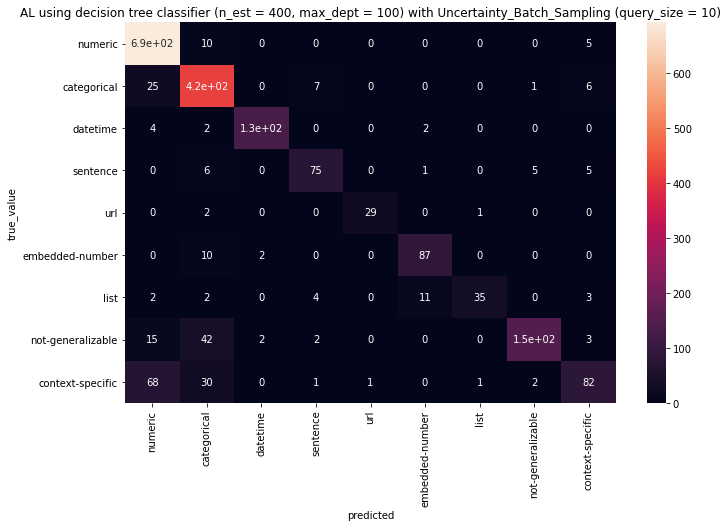

In [13]:
his_folder = "./his"
img_folder = "./img"
feed_folder = "./feed"

def train_this(n_est, max_dept, query_size, per_iteration_acc_report = True):
    
    # getting data
    X_train, y_train, X_sim, y_sim, X_test, y_test = get_data()
    
    # get learner
    preset_batch = partial(uncertainty_batch_sampling, n_instances=query_size)
    learner = ActiveLearner(\
    estimator=RandomForestClassifier(n_estimators=n_est, max_depth=max_dept, random_state=100),
        X_training=X_train, y_training=y_train,
        query_strategy=preset_batch
        )
    
    # init tracker lists
    num_queries = []
    time_history = []
    total_time_history = []
    train_acc_history = []
    sim_acc_history = []
    test_acc_history = []
    feed_to_learner = []
    
    # AL cycle
    t_start = time.time()
    num_of_queries = int(len(X_sim)/query_size) + 1
    
    num_of_queries = 1 #temp
    for i in range(num_of_queries):
        print(f"\n*********** QUERY {i} ***********remain:{len(X_sim)}")
        t0 = time.time()
        
        #AL selection
        query_idx, query_inst = learner.query(np.array(X_sim))
        print(f"Nodes returned for query in iteration {i}: {query_idx}")
        
        print(X_train.shape, y_train.shape)
        print(X_sim.shape, y_sim.shape)
        print(X_test.shape, y_test.shape)

        #updating learner
        learner.teach(X = X_sim.iloc[query_idx], y = y_sim.iloc[query_idx])
        feed_to_learner.append(list(query_idx))
        
        X_sim = X_sim.drop(list(query_idx))
        y_sim = y_sim.drop(list(query_idx))

        #df version
        # delete queries that have been looped back into the model
        #X_simulation_df = X_simulation_df.drop(X_simulation_df.index[query_idx])
        #y_simulation_df = y_simulation_df.drop(y_simulation_df.index[query_idx])

        #np version
        # learner.teach(X = pd.Series(X_simulation_np[idx]), y = y_simulation_np[idx])
        # X_simulation_np = np.delete(X_simulation_np, query_index, axis=0)
        # y_simulation_np = np.delete(y_simulation_np, query_index)
        
        # recording history
        t1 = time.time()
        time_history.append(t1 - t0)
        total_time_history.append(t1 - t_start)
        num_queries.append(len(feed_to_learner))

        # Calculate and report our model's accuracy.
        if per_iteration_acc_report:
            test_acc = learner.score(X_test, y_test)
            sim_acc = learner.score(X_sim, y_sim)
            train_acc = learner.score(X_train, y_train)
                
            test_acc_history.append(  test_acc  )
            sim_acc_history.append(   sim_acc   )
            train_acc_history.append( train_acc )
            print(f"\n[INTERMEDIATE] test_acc:{test_acc}, sim_acc:{sim_acc}, train_acc:{train_acc}")
            
        print(f"\n[INTERMEDIATE] Time taken for query {i}: {time_history[-1]}")
        print(f"\n[INTERMEDIATE] Total time taken {i}: {total_time_history[-1]}")

    # saving data into csv
    print("saving data")
    
    al_sampling = "Uncertainty_Batch_Sampling"
    file_name = f"{al_sampling}_ne{n_est}_dept{max_dept}_query{query_size}"
    
    data = {"num_queries": num_queries, "time": time_history, "total_time":total_time_history,\
            "train_accuracy":train_acc_history, "simulation_accuracy":sim_acc_history,\
            "test_accuracy":test_acc_history}
    save_his(data, f"{his_folder}/{file_name}.csv")
    
    # saving confusion matrix
    y_pred = learner.predict(X_test)
    con_matrix = confusion_matrix(y_test, y_pred)
    title = f"AL using decision tree classifier (n_est = {n_est}, max_dept = {max_dept}) with {al_sampling} (query_size = {query_size})"
    save_con_matrix(con_matrix, title, f"{img_folder}/{file_name}.png")
    
    # saving feed into pickle
    save_feed(feed_to_learner, f"{feed_folder}/{file_name}.pkl")
        
    print("completed")
    
train_this(n_est=400, max_dept=100, query_size=10)

dict_keys(['filename', 'num_queries', 'time', 'total_time', 'train_accuracy', 'simulation_accuracy', 'test_accuracy'])
dict_keys(['filename', 'num_queries', 'time', 'total_time', 'train_accuracy', 'simulation_accuracy', 'test_accuracy'])


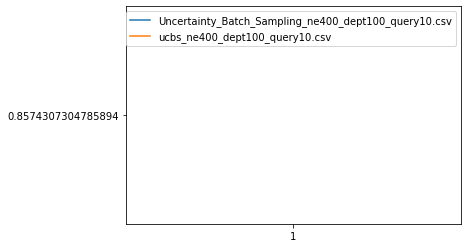

In [14]:
path = "./his"
files = os.listdir(path)

def get_results():
    for f in files:
        if f.endswith(".csv") and not f.startswith("test"):
            with open(f"{path}/{f}", mode='r') as infile:
                reader = csv.reader(infile)
                temp = zip(*reader)

                results = {"filename": f}
                for i in temp:
                    results[i[0]] = i[1:]
                yield results
                
for r in get_results():
    print(r.keys())
    plt.plot(r["num_queries"], r["test_accuracy"], label = r["filename"])
plt.legend()
plt.show()